In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, sosfiltfilt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import pyxdf


import cedalion
import cedalion.datasets as datasets
import cedalion.nirs
import cedalion.sigproc.motion_correct as motion_correct
import cedalion.sigproc.quality as quality
import cedalion.sim.synthetic_artifact as synthetic_artifact
import cedalion.plots as plots
from cedalion import units


np.float_ = np.float64

In [2]:
subject = "nc726"     
exp_path = f"/app/jasmin/data/raw/original/"

In [3]:
snirf_path = f"{exp_path}{subject}/ninja/{subject}.snirf"
recordings = cedalion.io.read_snirf(snirf_path)
rec = recordings[0]


In [4]:
def prepare_nirs(rec,
                 modality: str = "od",
                 bandpass: tuple[float, float] | None = None,
                 butter_order: int = 4,
                 channel: str | None = None,
                 wavelength: str | None = None):

    # pick raw amplitude or OD
    data = cedalion.nirs.int2od(rec["amp"]) if modality == "od" else rec["amp"]

    # apply bandpass filter via cedalion accessor
    if bandpass is not None:
        low, high = bandpass
        data = data.cd.freq_filter(low, high, butter_order=butter_order)

    # optionally select a single channel & wavelength
    if channel is not None and wavelength is not None:
        data = data.sel(channel=channel, wavelength=wavelength)



    return data



In [5]:
signal = prepare_nirs(rec,
                         modality="amp",
                         bandpass=(0.1, 0.5), # Heart: (0.5, 2.5) Hz, Breath: (0.1, 0.5) Hz
                         butter_order=4,
                         channel="S51D142",
                         wavelength="850")
channel = signal.channel
signal_times = signal.time



In [6]:
streams, header = pyxdf.load_xdf(f"{exp_path}{subject}/lsl.xdf")

for s in streams:
    name = s['info']['name'][0]
    n_samples = len(s['time_stamps'])
    ts = np.asarray(s.get('time_series', []))
    print(f"{name!r}: {n_samples} timestamps, data shape {ts.shape}")




'LiveAmpSN-102101-1018-STETriggerIn': 0 timestamps, data shape (0,)
'LiveAmpSN-102101-1018-DeviceTrigger': 0 timestamps, data shape (0,)
'PsychoPyMarker': 66 timestamps, data shape (66, 1)
'UnixTime_s': 6014 timestamps, data shape (6014, 1)
'HwSyncMarker': 3 timestamps, data shape (3, 1)
'LiveAmpSN-102101-1018': 2681174 timestamps, data shape (2681174, 5)
'Neon Companion_Neon Gaze': 1055763 timestamps, data shape (1055763, 16)
'Neon Companion_Neon Events': 4 timestamps, data shape (4, 1)


In [7]:
# 1) load LSL streams & find LiveAmp + PsychoPyMarker
liveamp = next(s for s in streams 
           if s['info']['name'][0] == 'LiveAmpSN-102101-1018')
psy = next(s for s in streams 
           if s['info']['name'][0] == 'PsychoPyMarker')

# 2) build respiration array
times     = np.asarray(liveamp['time_stamps'])
chan_group = liveamp['info']['desc'][0]['channels'][0]
chan_list  = chan_group['channel']
print('chan list: ', chan_list)
labels     = [ch['label'][0] for ch in chan_list]
print('LiveAmp labels: ', labels)
resp_idx  = labels.index('respiration')
resp_data = np.asarray(liveamp['time_series'])[:, resp_idx]
rel_times = times - times[0]

# 3) build PsychoPy event DataFrame
psy_times   = np.asarray(psy['time_stamps']) - times[0] 
psy_labels = [t[0] for t in psy['time_series']]
print('psy labels: ', psy_labels)
df_psy      = pd.DataFrame(dict(time=psy_times, label=psy_labels))

# 4) extract breath‐hold, tetris and conversation spans 
spans = []

patterns = {
    'breath-hold':   r'^bhb_\d+_bh_\d+$',
    'tetris':        r'^tetris_\d+$',
    'conversation':  r'^conversation_\d+$'
}


for label, pat in patterns.items():
    starts = df_psy[df_psy['label'].str.match(pat)]['time']
    for s in starts:
        future = df_psy[df_psy.time > s]['time']
        e = future.min()
        spans.append(dict(start=s,
                          end=e,
                          label=label))

chan list:  [defaultdict(<class 'list'>, {'label': ['respiration'], 'type': ['AUX'], 'unit': ['microvolts']}), defaultdict(<class 'list'>, {'label': ['gsr'], 'type': ['AUX'], 'unit': ['microvolts']}), defaultdict(<class 'list'>, {'label': ['ACC_X'], 'type': ['ACC'], 'unit': ['milliGs']}), defaultdict(<class 'list'>, {'label': ['ACC_Y'], 'type': ['ACC'], 'unit': ['milliGs']}), defaultdict(<class 'list'>, {'label': ['ACC_Z'], 'type': ['ACC'], 'unit': ['milliGs']})]
LiveAmp labels:  ['respiration', 'gsr', 'ACC_X', 'ACC_Y', 'ACC_Z']
psy labels:  ['bhb_1_instr', 'bhb_1_bh_1', 'bhb_1_recovery_1', 'bhb_1_bh_2', 'bhb_1_recovery_2', 'bhb_1_bh_3', 'bhb_1_recovery_3', 'bhb_1_bh_4', 'bhb_1_recovery_4', 'bhb_1_bh_5', 'bhb_1_recovery_5', 'bhb_1_rest', 'experiment_instr', 'conversation_instr_1', 'conversation_1', 'rest_instr_1', 'rest_1', 'tetris_instr_1', 'tetris_1', 'rest_instr_2', 'rest_2', 'tetris_instr_2', 'tetris_2', 'rest_instr_3', 'rest_3', 'conversation_instr_2', 'conversation_2', 'rest_inst

In [8]:
def prepare_resp(resp: np.ndarray,
                 times: np.ndarray,
                 bandpass: tuple[float, float] | None = None,
                 butter_order: int = 4) -> np.ndarray:


    if bandpass is None:
        return resp
    
    resp = np.asarray(resp, dtype=float)
    dt = np.diff(times)
    fs = 1.0 / dt.mean()
    nyq = fs / 2.0


    low, high = bandpass
    wn = [float(low/nyq), float(high/nyq)]
    print(f"fs={fs:.1f}Hz, Nyquist={nyq:.1f}Hz → wn={wn}")
    if not (0 < wn[0] < wn[1] < 1):
        raise ValueError(f"Invalid bandpass {bandpass} for fs={fs:.1f}Hz (wn={wn})")

    sos = butter(butter_order, wn, btype="band", output="sos")
    return sosfiltfilt(sos, resp)



In [9]:
resp_data = prepare_resp(resp_data, rel_times,
                         bandpass=(0.05, 1.0), butter_order=4) # (0.05, 1.0) Hz

fs=443.3Hz, Nyquist=221.7Hz → wn=[0.00022557735444213707, 0.004511547088842741]


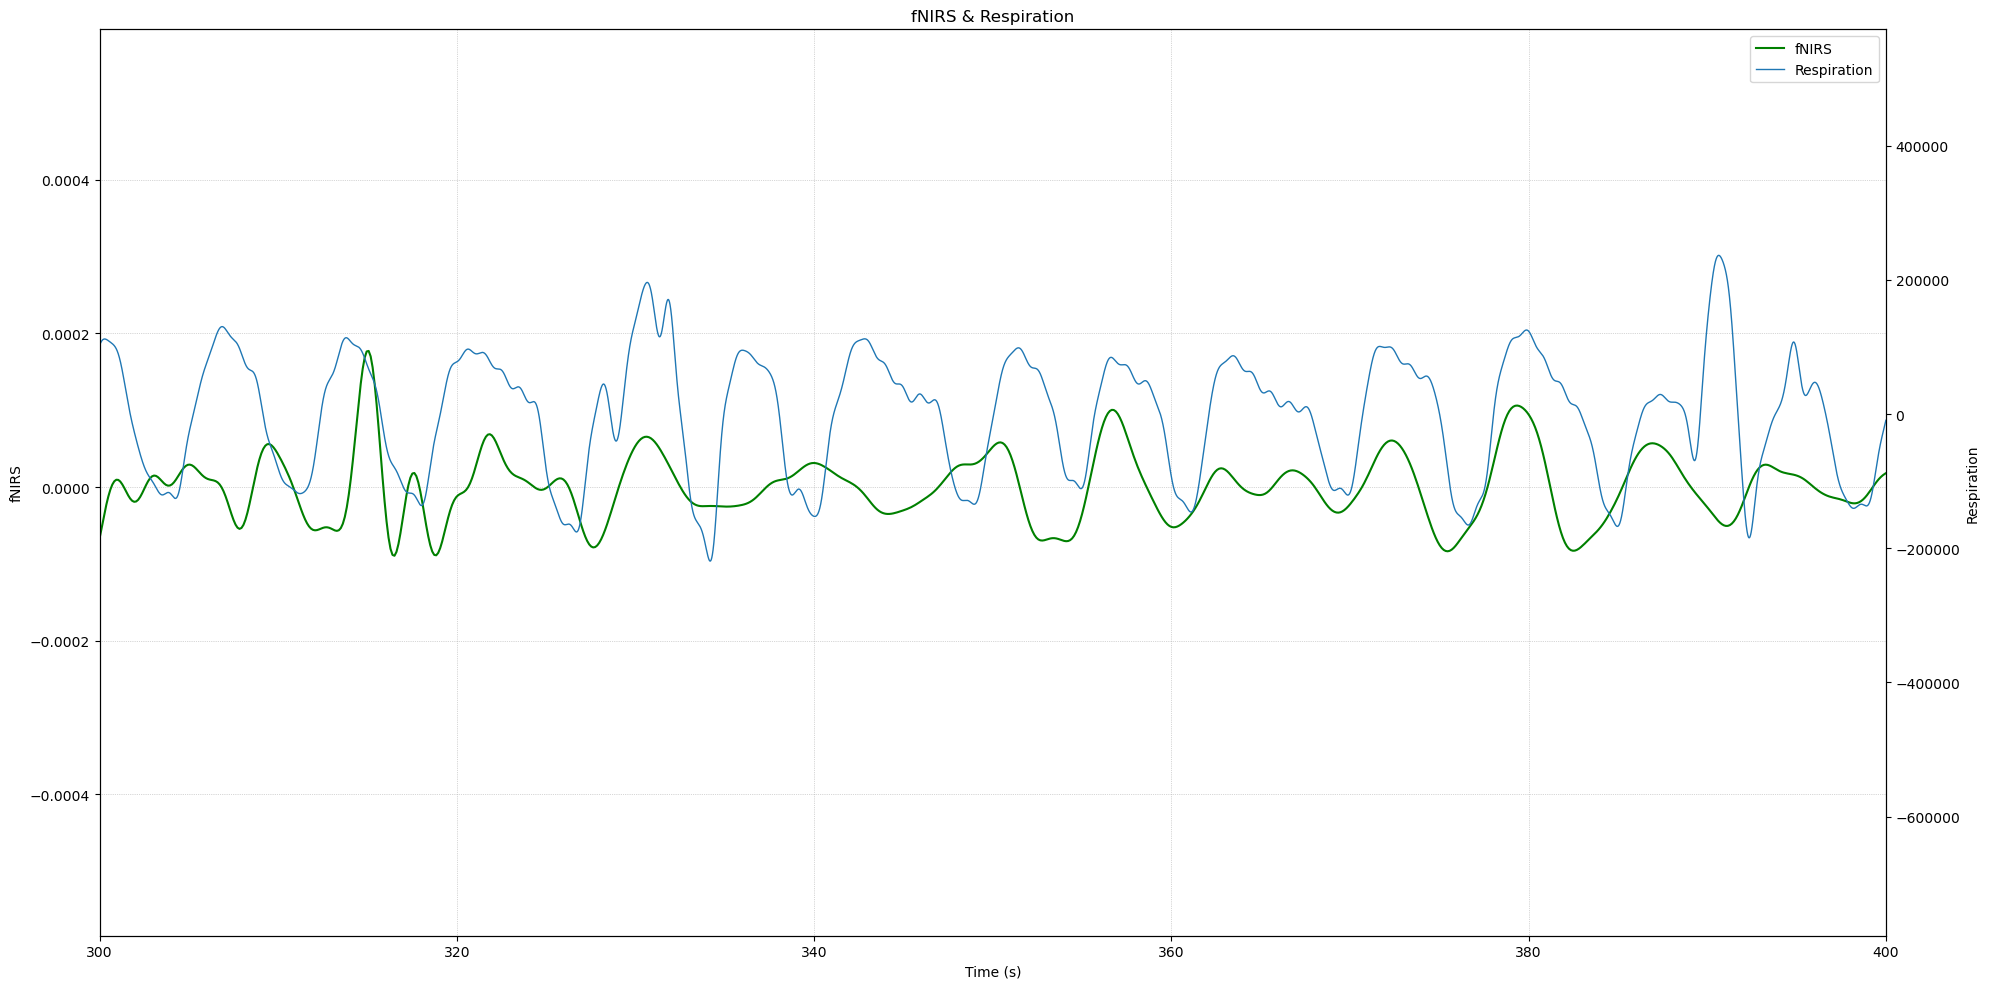

In [10]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(signal_times, signal,
         color='green', lw=1.5,
         label='fNIRS')
ax1.set_ylabel("fNIRS")
ax1.tick_params(axis='y')


ax2 = ax1.twinx()
ax2.plot(rel_times, resp_data, color='tab:blue', lw=1, label='Respiration')
ax2.set_ylabel("Respiration")
ax2.tick_params(axis='y')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

ax1.set_xlabel("Time (s)")
ax1.set_title("fNIRS & Respiration")
ax1.grid(ls=':', lw=0.5)
plt.xlim(300, 400)
plt.tight_layout()
plt.show()



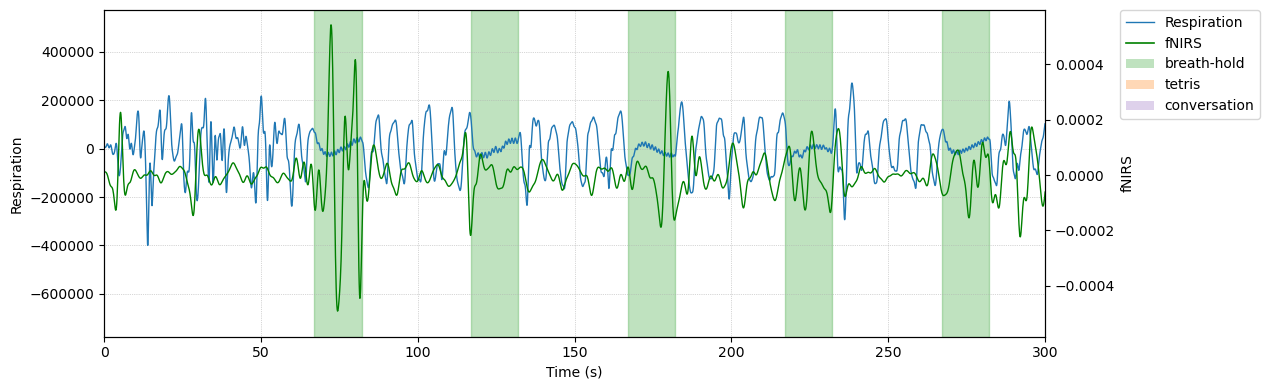

In [11]:
span_colors = {
    'breath-hold':  'tab:green',
    'tetris':        'tab:orange',
    'conversation':  'tab:purple'
}


fig, ax1 = plt.subplots(figsize=(14,4))


ax1.plot(rel_times, resp_data,
         color='tab:blue', lw=1, label='Respiration')

for sp in spans:
    ax1.axvspan(sp['start'], sp['end'],
                color=span_colors[sp['label']], alpha=0.3)

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Respiration")
ax1.tick_params(axis='y')
ax1.set_xlim(0, 300)

ax2 = ax1.twinx()
ax2.plot(signal_times, signal,
         color='green', lw=1, label='fNIRS')
ax2.set_ylabel("fNIRS")
ax2.tick_params(axis='y')

handles = [
  Line2D([0],[0], color='tab:blue', lw=1,   label='Respiration'),
  Line2D([0],[0], color='green',   lw=1.2, label='fNIRS')
] + [
  Patch(facecolor=col, alpha=0.3, label=lbl)
  for lbl, col in span_colors.items()
]

labels = [h.get_label() for h in handles]
ax1.legend(
    handles,
    labels,
    loc='upper left',
    bbox_to_anchor=(1.08, 1),
    borderaxespad=0
)

ax1.grid(ls=':', lw=0.5)
plt.tight_layout()
# make room on the right for the legend
plt.subplots_adjust(right=0.75)
plt.show()

/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


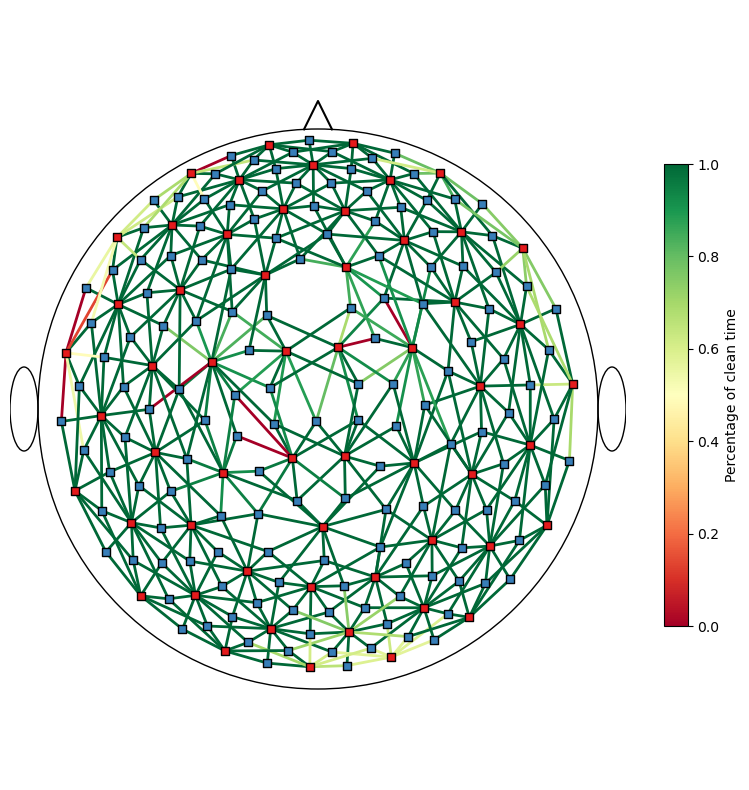

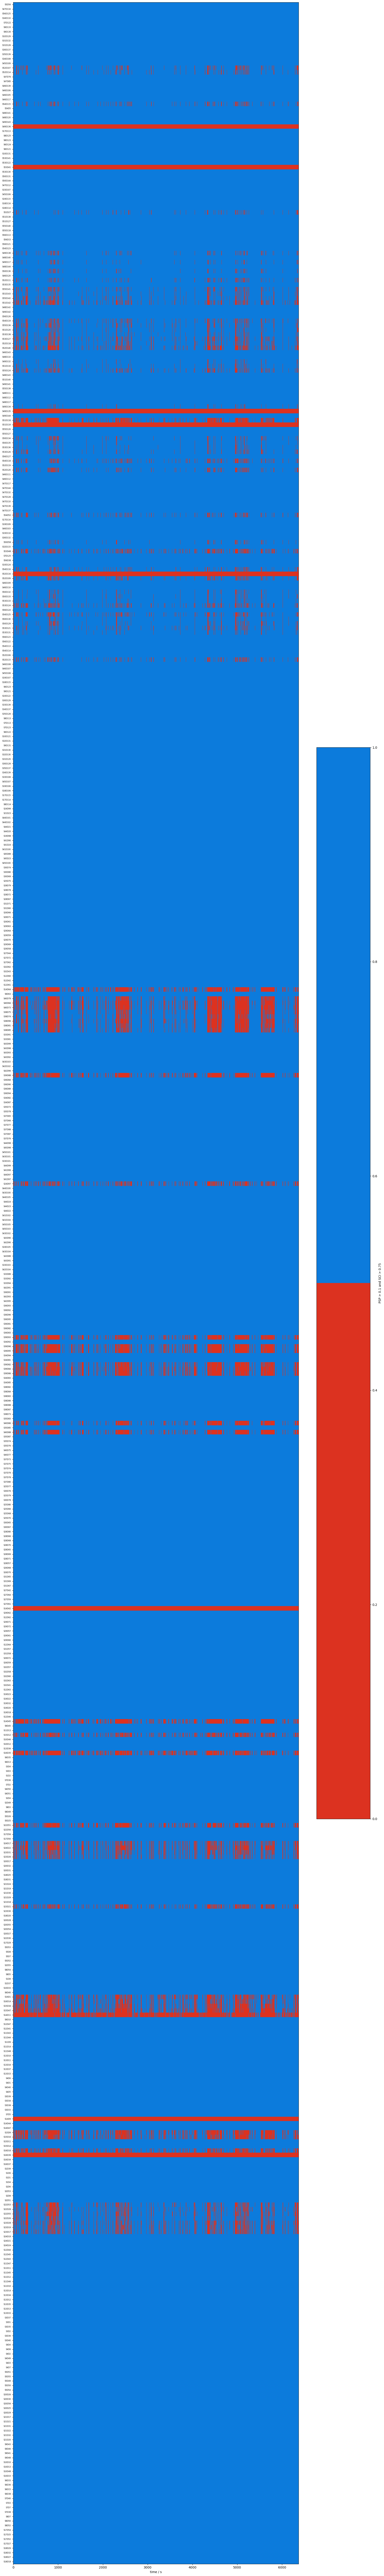

In [12]:
# Here we can assess the scalp coupling index (SCI) of the channels
sci_threshold = 0.75
window_length = 5*units.s
sci, sci_mask = quality.sci(rec["amp"], window_length, sci_threshold)
binary_nodes = [0, 0.5, 0.5, 1]
binary_colors= ["#DC3220", "#DC3220", "#0C7BDC", "#0C7BDC"]
sci_binary_cmap = LinearSegmentedColormap.from_list(
    "sci_binary_cmap", list(zip(binary_nodes, binary_colors))
)

# We can also look at the peak spectral power which takes the peak power of the cross-correlation signal between the cardiac band of the two wavelengths
psp_threshold = 0.1
psp, psp_mask = quality.psp(rec["amp"], window_length, psp_threshold)

sci_x_psp_mask = sci_mask & psp_mask
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)

# plot the percentage of clean time per channel
f,ax = plt.subplots(1,1,figsize=(8,8))
# plots.scalp_plot(rec, perc_time_clean, ax, colormap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')
# plots._simple_scalp_plot(rec['amp'], rec.geo3d, perc_time_clean, ax, cmap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')

plots.scalp_plot(
    rec["amp"],
    rec.geo3d,
    perc_time_clean,
    ax,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    title=None,
    cb_label="Percentage of clean time",
    channel_lw=2
)
f.tight_layout()

# binary heatmap of SCI>0.75 & PSP>0.1 with all channel labels shown
n_ch         = len(sci_x_psp_mask.channel)
inch_per_ch  = 0.2                          # vertical inches per channel
fig_height   = max(8, n_ch * inch_per_ch)   # ensure at least 8"

f, ax = plt.subplots(1, 1, figsize=(17, fig_height))
m = ax.pcolormesh(
    sci_x_psp_mask.time,
    np.arange(n_ch),
    sci_x_psp_mask,
    shading="nearest",
    cmap=sci_binary_cmap,
    edgecolors=None,
    linewidths=0
)
cb = plt.colorbar(m, ax=ax)
cb.set_label("PSP > 0.1 and SCI > 0.75")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(sci_x_psp_mask.channel.values, fontsize=6)

# give extra room on the left for long labels
plt.subplots_adjust(left=0.35)
plt.tight_layout()

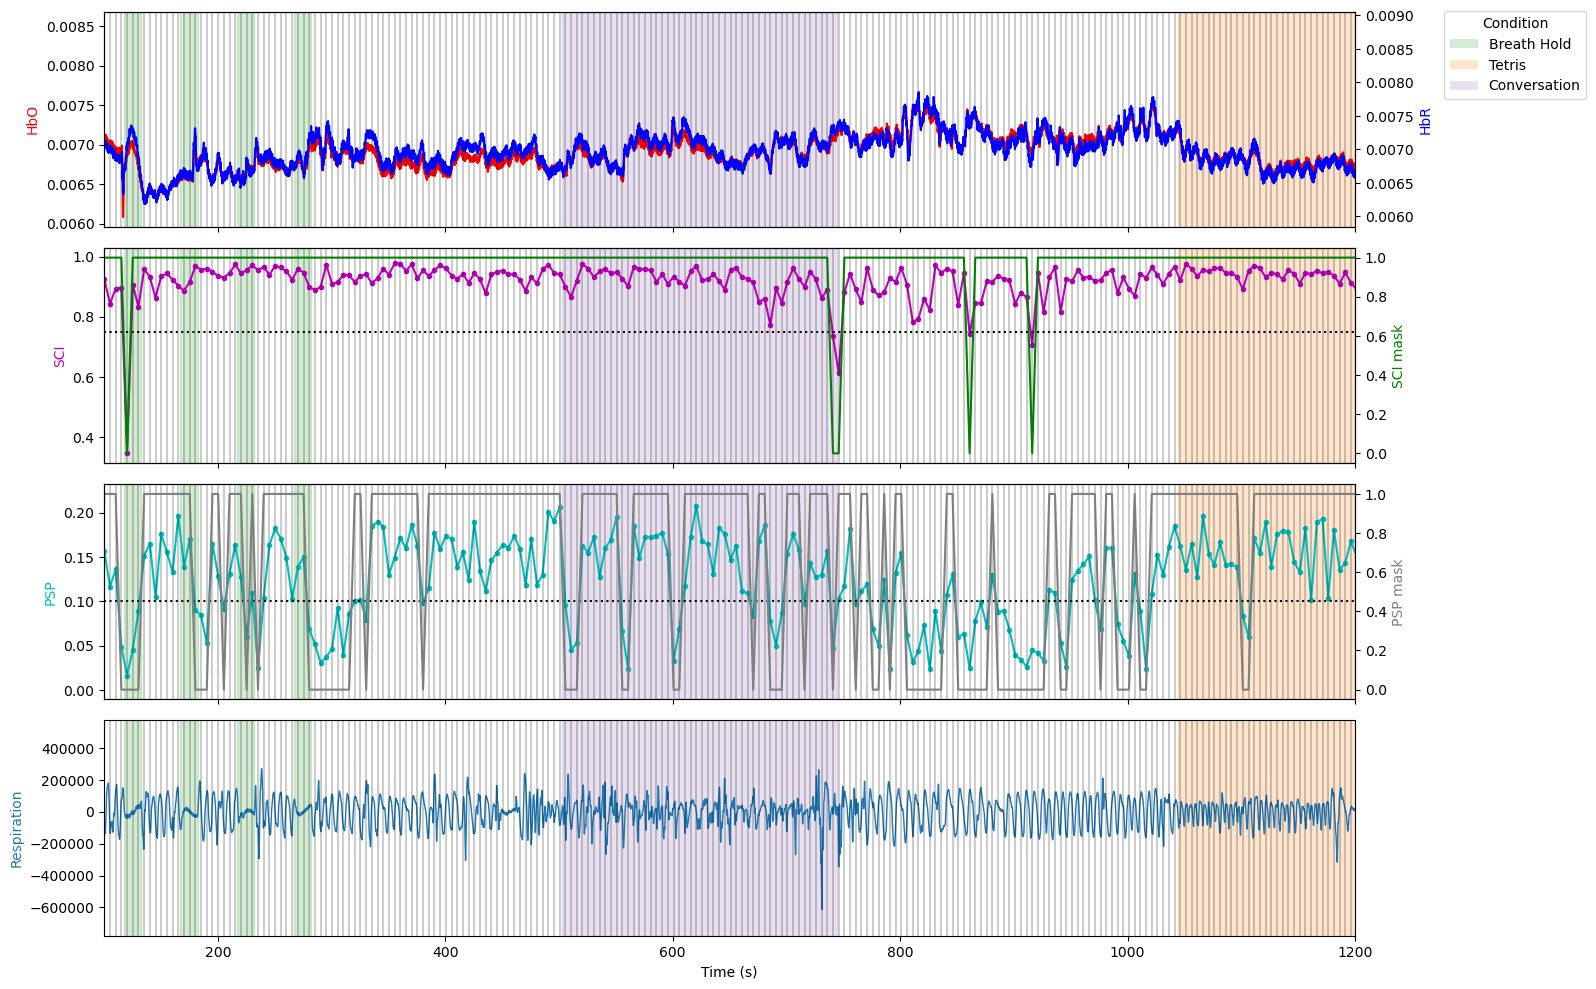

In [ ]:

ch = channel
t1, t2 = 100, 1200

# 1) set up 4-panel figure (HbO/HbR, SCI, PSP, Respiration)
fig, ax = plt.subplots(4, 1, figsize=(17, 10), sharex=True)

# 2) highlight spans across all panels
span_colors = {
    'breath-hold':  'tab:green',
    'tetris':        'tab:orange',
    'conversation':  'tab:purple'
}
for sp in spans:
    for a in ax:
        a.axvspan(sp['start'], sp['end'],
                  color=span_colors[sp['label']], alpha=0.2)

# 3) HbO & HbR on first panel
ax[0].plot(rec["amp"].time,
           rec["amp"].sel(channel=ch, wavelength=760), "r-")
ax[0].set_ylabel("HbO", color="r")
ax0b = ax[0].twinx()
ax0b.plot(rec["amp"].time,
          rec["amp"].sel(channel=ch, wavelength=850), "b-")
ax0b.set_ylabel("HbR", color="b")

# 4) SCI & SCI_mask on second panel
ax[1].plot(sci.time, sci.sel(channel=ch), "m.-")
ax[1].set_ylabel("SCI", color="m")
ax1b = ax[1].twinx()
ax1b.plot(sci_mask.time, sci_mask.sel(channel=ch), "g-")
ax1b.set_ylabel("SCI mask", color="g")
ax[1].axhline(sci_threshold, color="k", ls=":")
ax[1].set_xlim(t1, t2)

# 5) PSP & PSP_mask on third panel
ax[2].plot(psp.time, psp.sel(channel=ch), "c.-", label="PSP")
ax2b = ax[2].twinx()
# change mask color from black to gray
ax2b.plot(
    psp_mask.time,
    psp_mask.sel(channel=ch),
    color='tab:gray',
    lw=1.5,
    label="PSP mask"
)
ax[2].axhline(psp_threshold, color="k", ls=":")
ax[2].set_ylabel("PSP", color="c")
ax2b.set_ylabel("PSP mask", color="tab:gray")
ax[2].set_xlim(t1, t2)

# 6) Respiration on fourth panel
ax[3].plot(rel_times, resp_data,
           color='tab:blue', lw=1)
ax[3].set_ylabel("Respiration", color="tab:blue")
ax[3].set_xlabel("Time (s)")
ax[3].set_xlim(t1, t2)

# 7) common vertical lines (SCI window markers)
for i in sci.time.values:
    if t1 <= i <= t2:
        for a in ax:
            a.axvline(i, color="k", alpha=0.2)

# 8) legend for spans
from matplotlib.patches import Patch
span_handles = [
    Patch(facecolor=col, alpha=0.2, label=lbl.replace('-', ' ').title())
    for lbl, col in span_colors.items()
]
fig.legend(
    handles=span_handles,
    labels=[h.get_label() for h in span_handles],
    loc='upper right',
    bbox_to_anchor=(0.94, 0.99),
    title='Condition'
)

plt.tight_layout()
plt.subplots_adjust(right=0.80)
plt.show()

